# Mean-reversion

Mean reversion refers to the tendency of asset prices or values to return to their historical average over time, making deviations from this average temporary and subject to correction. If a price series is mean reverting, then  the current price level will tell us something about what the price's next move will be: If the price level is higher than the mean, the next move will be a downward move; if the price level is lower than the mean ,the next move will be an upward move. 



## Imports

In [800]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd
from hurst import compute_Hc
from arch.unitroot import VarianceRatio

## Data

First we specify the tickers we are interested in investigating, along with the period and time interval. 

In [801]:
tickers = ['PM', 'KO', 'MCD', 'JPM', 'TMO', 'CVX']
period = '2y'
interval = '1h'
num_decimals = 4

We then download the price series.

In [802]:
prices = [yf.Ticker(t).history(period=period, interval=interval)['Close'] for t in tickers]

In [803]:
prices_df = pd.DataFrame({ticker: price_series[(prices[0].index[:-1])] for ticker, price_series in zip(tickers, prices)})
prices_df

,PM,KO,MCD,JPM,TMO,CVX
2021-10-27 09:30:00-04:00,95.330002,55.715000,240.604996,169.052200,614.260010,112.925003
2021-10-27 10:30:00-04:00,95.110001,55.369999,241.210007,168.044998,613.049988,112.574997
2021-10-27 11:30:00-04:00,95.110001,55.634998,243.570007,168.070007,612.474976,112.650002
2021-10-27 12:30:00-04:00,94.989998,55.419998,243.000000,167.789993,618.869995,112.199997
2021-10-27 13:30:00-04:00,95.154999,55.470001,242.899994,168.210007,618.460022,112.239998
...,...,...,...,...,...,...
2023-10-26 11:30:00-04:00,90.151802,56.230000,258.230011,140.490005,440.059998,154.020004
2023-10-26 12:30:00-04:00,89.910004,56.174999,257.700012,140.300003,441.179993,154.070007
2023-10-26 13:30:00-04:00,90.000000,56.099998,257.670013,141.050003,443.578094,153.839996
2023-10-26 14:30:00-04:00,89.830002,55.970001,257.170013,141.149994,440.459991,154.610001


Plot the price series

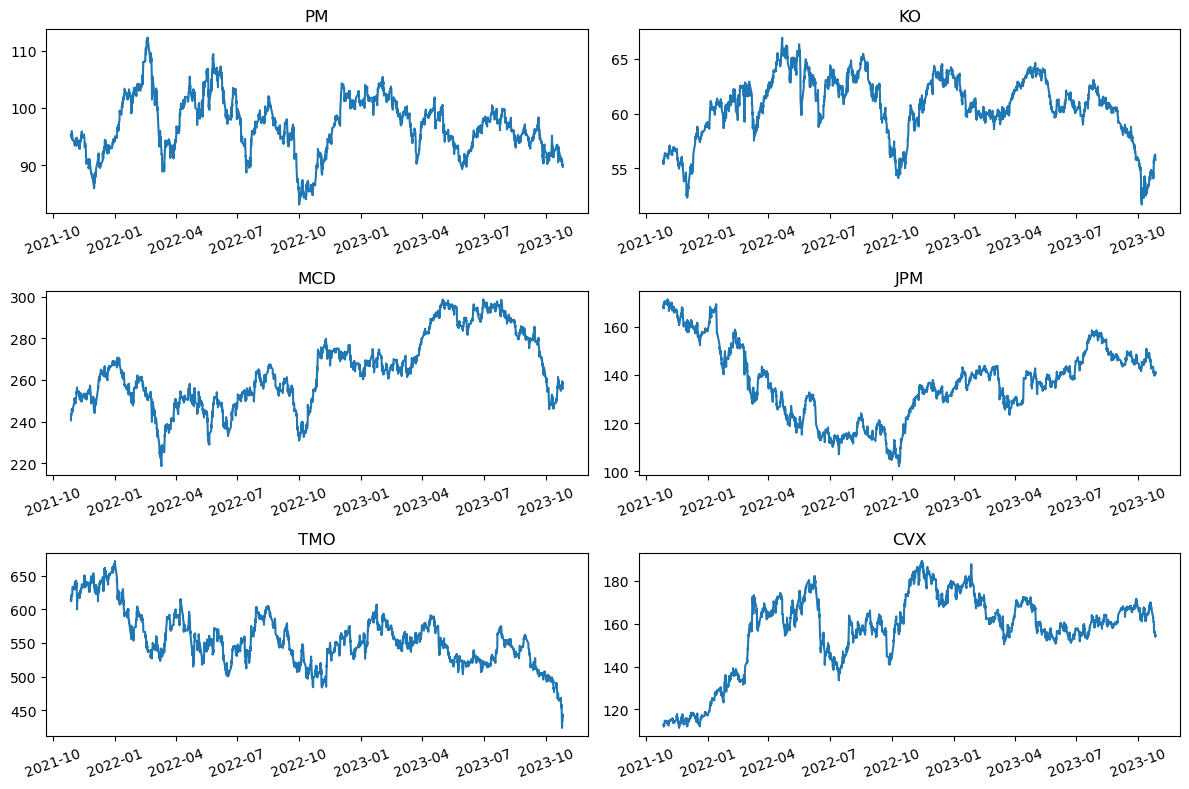

In [804]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i in range(len(prices)):
    row = i // 2
    col = i % 2
    axs[row, col].plot(prices[i].index, prices[i])
    axs[row, col].set_title(tickers[i])
    axs[row, col].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

### ADF test

The mathematical description of a mean-reverting prices series is that the change of the price series in the next period is proportional to the difference between the mean price and the current price. 
This is the basis of the Augmented Dicket-Fuller (ADF) test, which tests whether we can reject the null hypothesis that the proportionality constant is zero. 

We describe price changes using a linear model: 
$$ \Delta R(t) = \lambda R(t-1) + \mu + \beta_t + \alpha_1 \Delta R(t-1) + ... + \alpha_k \Delta R(t-k) + \epsilon_t $$

where $\Delta R(t)=R(t) - R(t-1)$, $\Delta R(t-1) = R(t-1) - R(t-2)$, and so on. The ADF test will find out if $\lambda=0$. If the hypothesis $\lambda=0$ can be rejected, it means the next move $\Delta R(t)$ depends on the current level, and therefore is not a random walk. 


The test statistic $\lambda/ SE(\lambda)$ is a measure of how long it takes for a price to mean revert. 



The null hypothesis is that the unit root (feature of some stochastic processes) is present in the time series $R(t)$, indicating the series is non-stationary. 

The ADF test will give us variables: 
* The ADF (test) statistic,
* The p-value of the test,
* Critical values of 1/5/10% significance level


If the ADF Statistic is less than the critical values and the p-value is less than your chosen significance level (e.g., 0.1), you can reject the null hypothesis, indicating that the time series is stationary.

If the ADF Statistic is greater than the critical values and the p-value is greater than the chosen significance level, you fail to reject the null hypothesis, indicating that the time series is non-stationary.

In [805]:
adf_results_df = pd.concat([
    pd.DataFrame({
        "Ticker": [ticker],
        "ADF Statistic": [round(result[0], num_decimals)],
        "p-value": [round(result[1], num_decimals)],
        "Critical Values (1%/5%/10%)": [list(round(val, num_decimals) for val in result[4].values())]
    })
    for ticker, result in zip(tickers, (adfuller(price) for price in prices))
], ignore_index=True)
adf_results_df.set_index("Ticker", inplace=True)
adf_results_df

,ADF Statistic,p-value,Critical Values (1%/5%/10%)
Ticker,,,
PM,-2.7980,0.0586,"[-3.4322, -2.8624, -2.5672]"
KO,-2.5783,0.0976,"[-3.4322, -2.8624, -2.5672]"
MCD,-1.9859,0.2928,"[-3.4322, -2.8624, -2.5672]"
JPM,-2.3081,0.1694,"[-3.4322, -2.8624, -2.5672]"
TMO,-1.9444,0.3115,"[-3.4322, -2.8624, -2.5672]"
CVX,-2.6082,0.0913,"[-3.4322, -2.8624, -2.5672]"


### Hurst exponent

The Hurst exponent $H$ is a fractal property of a time series $R(t)$ whose increments, after detrending, scale on average as 
$$ | R(t+\tau) - R(t) | \propto \tau^H $$
For
* $H=1/2$ is a Weiner process describing an unpredictable Brownian motion, 
* $H>1/2$ indicates persistence which indicates momentum, 
* $H<1/2$ indicates antipersistence which indicates mean-reversion. 

In [806]:
hurst_results_df = pd.concat([
    pd.DataFrame({
        "Ticker": [ticker],
        "Hurst Exponent": [round(result[0], num_decimals)],
    })
    for ticker, result in zip(tickers, (compute_Hc(price) for price in prices))
], ignore_index=True)
hurst_results_df.set_index("Ticker", inplace=True)
hurst_results_df

,Hurst Exponent
Ticker,
PM,0.4629
KO,0.4677
MCD,0.4864
JPM,0.5198
TMO,0.4480
CVX,0.4980


### Variance ratio

We can test the null hypothesis that a time series is a random walk using a variance ratio test. 

In [807]:
for price, ticker in zip(prices, tickers): 
    vr = VarianceRatio(price)
    print(ticker + vr.summary().as_text())

PM     Variance-Ratio Test Results     
Test Statistic                  0.805
P-value                         0.421
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
KO     Variance-Ratio Test Results     
Test Statistic                  1.211
P-value                         0.226
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
MCD     Variance-Ratio Test Results     
Test Statistic                 -0.721
P-value                         0.471
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
JPM     Variance-Ratio Test Results     
Test Statistic                  0.577
P-value                         0.564
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
TMO     Variance-Ratio Test Results     
Test 

### Half-life of mean reversion

If we transform the discrete time series from above to a differential form so that the changes in prices becomes infinitesimal quantities (and ignore the drift $\beta_t$ and the lagged differences $\Delta R(t-1), ..., \Delta R(t-k)$) then it becomes recognizable as the Ornstein-Uhlenbeck formula for a mean-reverting process
$$ d R(t) = (\lambda R(t-1) + \mu)dt + d\epsilon $$
where $d \epsilon$ is some Gaussian noise. 
We find the $\lambda$ using the ADF test, where we apply linear regression of $\Delta R(t)$ against $R(t-1)$, and this value carries over to the differential form. 
The analytical solution for the expected value of $R(t)$ is
$$ E[R(t)] = R_0 \exp{(\lambda t)} - \mu / \lambda (1-\exp{(\lambda t)}) $$

Since $\lambda$ is negative for a mean-reverting process, the expected value of the price decays exponentially to the value $-\mu/\lambda$ with the half-life of decay equal to $-\log{(2)}/\lambda$. 
Therefore, a mean-reverting strategy will not work if $\lambda>0$. 
Furthermore, if $\lambda$ is very close to zero, this means that the half-life will be very long, and a mean-reverting strategy will not be very profitable because we won't be able to complete many round-trip trades in a given time period. 
Lastly, $\lambda$ determines a natural time scale for many parameters in our strategy. Often, setting the look-back to equal a small multiple ($\geq 1$) of the half-life is close to optimal. 

In [808]:
def get_halflife(y): 
    ylag = np.roll(y, 1)
    deltaY = y - ylag
    deltaY = deltaY[1:]
    ylag = ylag[1:]
    X = np.column_stack((ylag, np.ones(len(ylag))))
    ols_model = sm.OLS(deltaY, X).fit()
    beta_1 = ols_model.params[0]
    halflife = -np.log(2) / beta_1
    return halflife

In [809]:
half_life_df = pd.concat([
    pd.DataFrame({
        "Ticker": [ticker],
        "Half life": [get_halflife(price)],
    })
    for ticker, price in zip(tickers, prices)
], ignore_index=True)
half_life_df.set_index("Ticker", inplace=True)
half_life_df


,Half life
Ticker,
PM,147.102168
KO,177.729082
MCD,315.593558
JPM,316.356382
TMO,186.012003
CVX,247.276249


### Linear mean-reverting strategy

We define a simple linear strategy for trading mean-reverting price series: 
Determine the normalized deviation of the price from its moving average, and maintain the number of units in this asset negatively proportional to this normalized deviation. 
The lookback for the moving average and standard deviation is set to the half-life. 

$$ mktVal = - (R - MA(R, lookback)) / MSTD(R, lookback) $$

In [810]:
mktVal = [- (price - price.rolling(max(1, round(lookback[0]))).mean()) / price.rolling(max(1, round(lookback[0]))).std() for price, lookback in zip(prices, half_life_df.values)]
#mktVal = [m.clip(-1, 1) for m in mktVal]

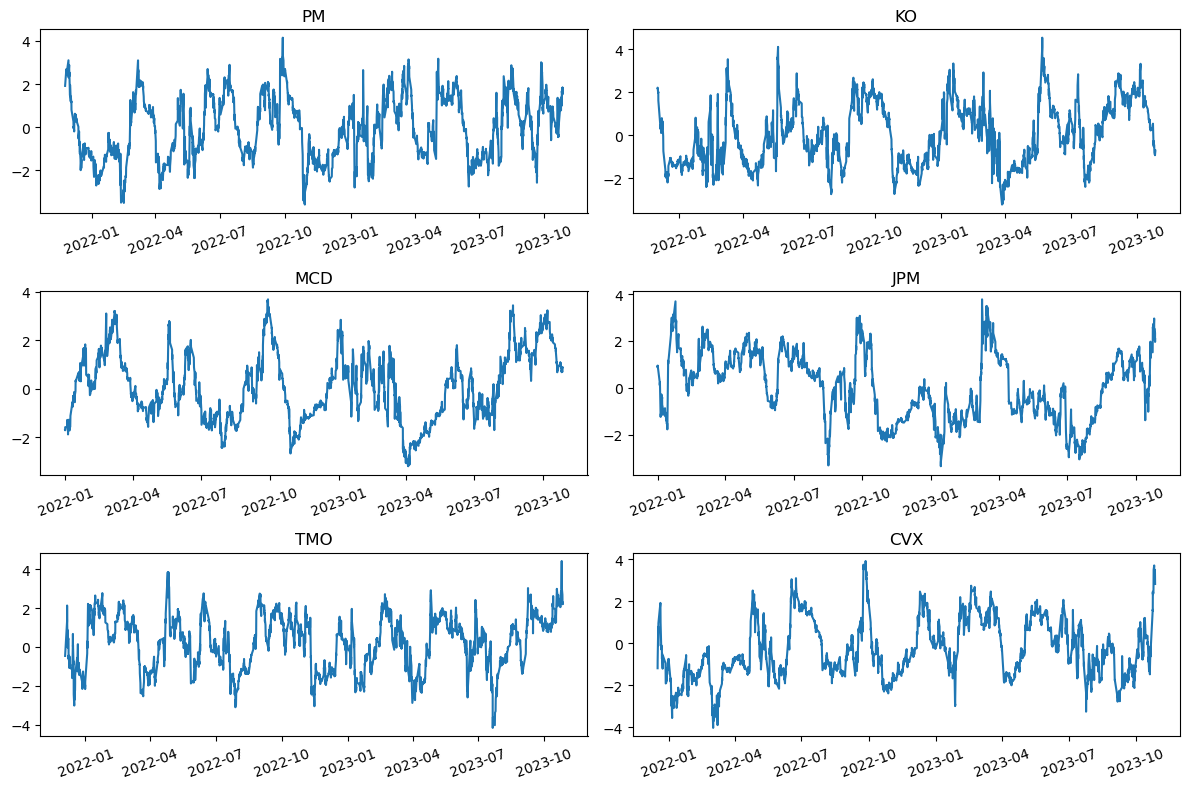

In [811]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i in range(len(prices)):
    row = i // 2
    col = i % 2
    axs[row, col].plot(mktVal[i].index, mktVal[i])
    axs[row, col].set_title(tickers[i])
    axs[row, col].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

We can then calculate the performance (P&L) of this strategy. Keep in mind that this does not account for transaction costs and assumes a frictionless market. 

In [812]:
pnl = [mval.shift(1) * (price - price.shift(1)) / price.shift(1) for price, mval in zip(prices, mktVal)]
pnl = [p.fillna(0).add(1) for p in pnl]

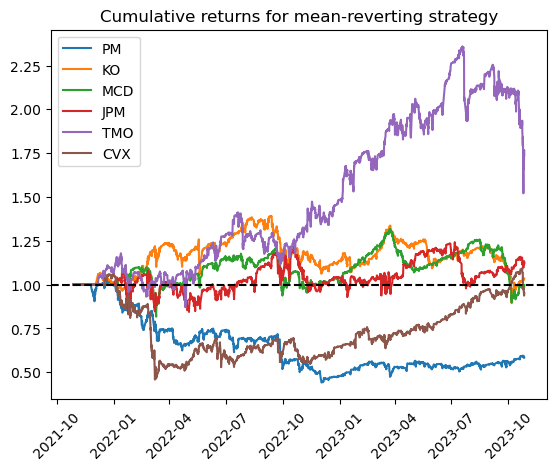

In [813]:
fig, ax = plt.subplots()

for p, ticker in zip(pnl, tickers):
    ax.plot(p.cumprod(), label=ticker)
ax.legend()
plt.title('Cumulative returns for mean-reverting strategy')
ax.axhline(y=1, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

## Cointegration

We can combine $\geq 2$ individual price series that are not mean reverting into a portfolio whose net market value is mean reverting through cointegration. 

The typical 'pairs trading' strategy is based on cointegration of going long one asset and simultaneously shorting another. 


### CADF test

The cointegrated augmented Dickey-Fuller (CADF) test will tell us what hedge ratios we should use to combine assets to form a stationary portfolio. First we determine the optimal hedge ratio by running a linear regression fit between two price series, and then we use this hedge ratio to form a portfolio. Finally, we run a stationarity test on this portfolio. 

In [814]:
p_cointegration_matrix = np.zeros((len(prices), len(prices)))
for i in range(len(prices)):
    for j in range(i + 1, len(prices)):
        result = sm.tsa.coint(prices[i], prices[j])
        p_cointegration_matrix[i, j] = p_cointegration_matrix[j, i] = round(result[1], num_decimals)
p_cointegration_df = pd.DataFrame(p_cointegration_matrix, columns=tickers, index=tickers)
p_cointegration_df

,PM,KO,MCD,JPM,TMO,CVX
PM,0.0000,0.0611,0.1728,0.1761,0.1426,0.1696
KO,0.0611,0.0000,0.3596,0.1325,0.2255,0.2638
MCD,0.1728,0.3596,0.0000,0.3405,0.5246,0.5931
JPM,0.1761,0.1325,0.3405,0.0000,0.5925,0.2694
TMO,0.1426,0.2255,0.5246,0.5925,0.0000,0.0357
CVX,0.1696,0.2638,0.5931,0.2694,0.0357,0.0000


We find the optimal hedge ratio using OLS regression. Unfortunately the results are not symmetric (i.e., [i, j] != [j, i]). 

In [815]:
hedge_ratio_matrix = np.zeros((len(prices), len(prices)))
for i in range(len(prices)):
    for j in range(len(prices)):
        if i!=j:
            result = sm.OLS(prices[i][:-1], sm.add_constant(prices[j][:-1])).fit()
            hedge_ratio_matrix[i, j] = round(result.params[1], num_decimals)
hedge_ratio_df = pd.DataFrame(hedge_ratio_matrix, columns=tickers, index=tickers)
hedge_ratio_df

,PM,KO,MCD,JPM,TMO,CVX
PM,0.0000,1.0982,0.0078,0.0186,0.0217,0.0528
KO,0.3605,0.0000,0.0382,-0.0666,0.0042,0.0576
MCD,0.0938,1.3936,0.0000,0.3549,-0.0455,0.1785
JPM,0.1773,-1.9303,0.2818,0.0000,0.1626,-0.3925
TMO,1.3749,0.8036,-0.2403,1.0816,0.0000,-1.2264
CVX,0.6915,2.2982,0.1950,-0.5402,-0.2537,0.0000


We can visualize the cointegrated portfolio of two assets combined with the hedge ratio found above. 

In [816]:
hedged_portfolio_matrix = []
hedged_portfolio_titles = []
for i in range(len(prices)):
    for j in range(len(prices)):
        if i!=j:
            hedged_portfolio_matrix.append(prices[i][:-1] - hedge_ratio_df[tickers[i]][tickers[j]] * prices[j][:-1])
            sign = '+' if hedge_ratio_df[tickers[i]][tickers[j]] < 0 else '-'
            hedged_portfolio_titles.append(f'{tickers[i]} {sign} {abs(hedge_ratio_df[tickers[i]][tickers[j]])} * {tickers[j]}')
hedged_portfolio_df = pd.concat(hedged_portfolio_matrix, axis=1)
hedged_portfolio_df.columns = hedged_portfolio_titles
hedged_portfolio_df

,PM - 0.3605 * KO,PM - 0.0938 * MCD,PM - 0.1773 * JPM,PM - 1.3749 * TMO,PM - 0.6915 * CVX,KO - 1.0982 * PM,KO - 1.3936 * MCD,KO + 1.9303 * JPM,KO - 0.8036 * TMO,KO - 2.2982 * CVX,...,TMO - 0.0217 * PM,TMO - 0.0042 * KO,TMO + 0.0455 * MCD,TMO - 0.1626 * JPM,TMO + 0.2537 * CVX,CVX - 0.0528 * PM,CVX - 0.0576 * KO,CVX - 0.1785 * MCD,CVX + 0.3925 * JPM,CVX + 1.2264 * TMO
2021-10-27 09:30:00-04:00,75.244744,72.761253,65.357047,-749.216086,17.242362,-48.976408,-279.592122,382.036462,-437.904344,-203.809242,...,612.191349,614.026007,625.207537,586.772122,642.909083,107.891579,109.715819,69.977011,179.277992,866.253479
2021-10-27 10:30:00-04:00,75.149116,72.484502,65.315622,-747.772428,17.264390,-49.079804,-280.780266,379.747259,-437.276971,-203.349859,...,610.986101,612.817434,624.025043,585.725871,641.610265,107.553189,109.385685,69.519011,178.532659,864.419502
2021-10-27 11:30:00-04:00,75.053584,72.263134,65.311188,-746.981843,17.212525,-48.814804,-283.804164,380.060533,-436.549892,-203.257235,...,610.411089,612.241309,623.557411,585.146792,641.054281,107.628193,109.445426,69.172755,178.617479,863.789312
2021-10-27 12:30:00-04:00,75.011089,72.196598,65.240832,-755.894358,17.403700,-48.898017,-283.224802,379.305022,-441.903930,-202.438035,...,616.808712,618.637231,629.926495,591.587342,647.335134,107.184525,109.007805,68.824497,178.057569,871.182159
2021-10-27 13:30:00-04:00,75.158063,72.370979,65.331365,-755.165685,17.541040,-49.029218,-283.035430,380.165777,-441.524472,-202.479962,...,616.395158,618.227048,629.511972,591.109075,646.935309,107.215814,109.044926,68.882349,178.262425,870.719369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-26 11:30:00-04:00,69.880887,65.929827,65.242924,-514.886689,-16.353031,-42.774709,-303.639344,327.417857,-297.402214,-297.738774,...,438.103703,439.823832,451.809463,417.216323,479.134873,149.259989,150.781156,107.925947,209.162331,693.709585
2023-10-26 12:30:00-04:00,69.658916,65.737743,65.034813,-516.668368,-16.629406,-42.564167,-302.955738,326.996095,-298.357243,-297.908692,...,439.228946,440.944058,452.905343,418.367212,480.267554,149.322759,150.834327,108.070555,209.137759,695.133150
2023-10-26 13:30:00-04:00,69.775951,65.830553,64.991834,-519.875522,-16.380357,-42.738002,-302.988932,328.368819,-300.359358,-297.455081,...,441.625094,443.342474,455.302080,420.643364,482.607302,149.087996,150.608636,107.845899,209.202123,697.844171
2023-10-26 14:30:00-04:00,69.652816,65.707455,64.804108,-515.758440,-17.082814,-42.681307,-302.422129,328.431834,-297.983648,-299.354702,...,438.510680,440.224917,452.161227,417.509002,479.684549,149.866977,151.386129,108.705153,210.011373,694.790134


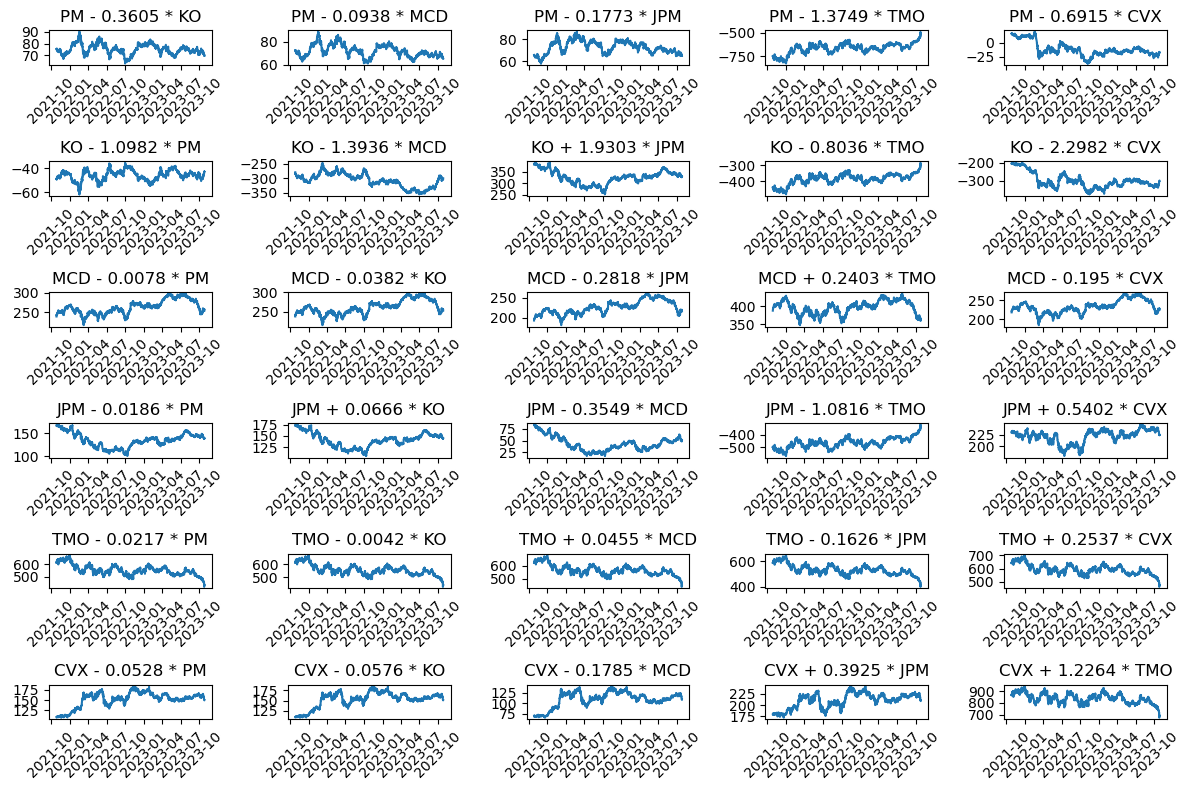

In [817]:
fig, axs = plt.subplots(6, 5, figsize=(12, 8))
col, row = 0, 0

for portfolio in hedged_portfolio_df:
        axs[row, col].plot(hedged_portfolio_df.index, hedged_portfolio_df[portfolio])
        axs[row, col].set_title(portfolio)
        axs[row, col].tick_params(axis='x', labelrotation=45)
        
        col+=1
        if col >= 5:
            col=0
            row+=1

plt.tight_layout()
plt.show()

We see that these price series look more stationary. Now we can run a ADF test on these hedged portfolios. 

In [818]:
adf_hedged_portfolio_results_df = pd.concat([
    pd.DataFrame({
        "Ticker": [ticker],
        "ADF Statistic": [round(result[0], num_decimals)],
        "p-value": [round(result[1], num_decimals)],
        "Critical Values (1%/5%/10%)": [list(round(val, num_decimals) for val in result[4].values())]
    })
    for ticker, result in zip(hedged_portfolio_titles, (adfuller(hedged_portfolio_df[x]) for x in hedged_portfolio_df))
], ignore_index=True)
adf_hedged_portfolio_results_df.set_index("Ticker", inplace=True)
adf_hedged_portfolio_results_df

,ADF Statistic,p-value,Critical Values (1%/5%/10%)
Ticker,,,
PM - 0.3605 * KO,-2.9373,0.0412,"[-3.4322, -2.8624, -2.5672]"
PM - 0.0938 * MCD,-2.6259,0.0878,"[-3.4322, -2.8624, -2.5672]"
PM - 0.1773 * JPM,-2.4251,0.1348,"[-3.4322, -2.8624, -2.5672]"
PM - 1.3749 * TMO,-2.0512,0.2646,"[-3.4322, -2.8624, -2.5672]"
PM - 0.6915 * CVX,-2.5735,0.0986,"[-3.4322, -2.8624, -2.5672]"
KO - 1.0982 * PM,-3.3301,0.0136,"[-3.4322, -2.8624, -2.5672]"
KO - 1.3936 * MCD,-1.8203,0.3704,"[-3.4322, -2.8624, -2.5672]"
KO + 1.9303 * JPM,-2.3697,0.1505,"[-3.4322, -2.8624, -2.5672]"
KO - 0.8036 * TMO,-2.0772,0.2538,"[-3.4322, -2.8624, -2.5672]"


### Johansen test

A way of testing cointegration of more than two variables. We do this by generalizing the equation from the ADF test to where $R(t)$ is the vector representing mutiple price series, and the coefficients $\lambda, \alpha$ are matrices. We assume $\beta_t=0$ for simplicity. 

$$ \Delta R(t) = \lambda R(t-1) + \mu + \alpha_1 \Delta R(t-1) + ... + \alpha_k \Delta R(t-k) + \epsilon_t $$

Just as in the univariate case, if $\lambda=0$, we do not have cointegration. 

The number of price series is denoted by $n$. 
Let $r$ be the number of independent portfolios that can be formed by varios linear combinations of the cointegrating price series ($r$ is also the rank of $\lambda$). 

There are two types of Johansen tests/ways of calculating $r$, both of which are based on eigenvector decomposition of $\lambda$. 
We will look at the trace test first: 

In [819]:
result = coint_johansen(prices_df, det_order=0, k_ar_diff=1)
index_j = [f'r<={x}' for x in range(6)]

trace_stats = pd.Series(result.trace_stat, index=index_j, name="Trace Statistics")
critical_values = pd.DataFrame(result.trace_stat_crit_vals, columns=[90,95,99], index=index_j)
critical_values.columns = [f"{alpha}% Significance" for alpha in [90,95,99]]
trace_df = pd.concat([trace_stats, critical_values], axis=1)
trace_df

,Trace Statistics,90% Significance,95% Significance,99% Significance
r<=0,95.358665,91.1090,95.7542,104.9637
r<=1,60.527087,65.8202,69.8189,77.8202
r<=2,37.188530,44.4929,47.8545,54.6815
r<=3,18.058088,27.0669,29.7961,35.4628
r<=4,7.308633,13.4294,15.4943,19.9349
r<=5,2.535806,2.7055,3.8415,6.6349


We see that the hypothesis $r=0$ is rejected at $95\%$ significance, while we can't reject $r<=1$ at $90\%$ significance. Therefore, we conclude that there is one cointegrating relatinship between our 6 stocks. 

The other type of Johansen test is the eigenvalue test. 

In [820]:
eigenvalue_stats = pd.Series(result.max_eig_stat, index=index_j, name="Eigenvalue Statistics")
critical_values = pd.DataFrame(result.max_eig_stat_crit_vals, columns=[90,95,99], index=index_j)
critical_values.columns = [f"{alpha}% Significance" for alpha in [90,95,99]]
eigenvalue_df = pd.concat([eigenvalue_stats, critical_values], axis=1)
eigenvalue_df

,Eigenvalue Statistics,90% Significance,95% Significance,99% Significance
r<=0,34.831578,37.2786,40.0763,45.8662
r<=1,23.338557,31.2379,33.8777,39.3693
r<=2,19.130442,25.1236,27.5858,32.7172
r<=3,10.749455,18.8928,21.1314,25.8650
r<=4,4.772826,12.2971,14.2639,18.5200
r<=5,2.535806,2.7055,3.8415,6.6349


For this test we see that we get different result that the trace test, and we can't even reject the null hypothesis $r=0$ at $90\%$ significance. 

A useful by-product is that the eigenvectors found can be used as our hedge ratios for the individual price sereies to form a stationary portfolio. 

In [821]:
print('Eigenvalues:\n', result.eig)
print('Eigenvectors:\n', result.evec)

Eigenvalues:
 [0.00987445 0.0066271  0.00543544 0.00305784 0.00135886 0.00072219]
Eigenvectors:
 [[ 1.69045515e-01 -2.38941403e-01 -7.23909137e-02  8.46845435e-02
  -4.91569630e-04 -5.80548613e-02]
 [-6.04006221e-01  1.49007825e-01  3.95726078e-02 -2.53483727e-01
   4.45295208e-03 -8.12377449e-02]
 [ 5.97413436e-02 -1.44922596e-02 -1.65046226e-02 -2.26551950e-02
   4.77923096e-02  6.95142144e-03]
 [-9.66224734e-02  1.62561457e-02 -2.71654223e-02  4.03636453e-03
  -2.90668363e-02  5.04966222e-02]
 [ 1.51092697e-02  1.90548977e-02 -1.35644822e-02  1.50890570e-02
   1.01402634e-02 -1.33256894e-02]
 [ 9.56496568e-03  4.49914423e-02 -4.71517623e-02  4.92816940e-03
  -4.32642154e-02  2.13649175e-03]]


The eigenvectors are ordered in decreasing order of their corresponding eigenvalues. Therefore, the first cointegrating relation is the 'strongest' with the shortest half-life for mean reversion. The first eigenvector is therefore the natural candidate to form a stationary portfolio. 

### Linear mean-reverting trading on a portfolio

We select the 4 most promising cointigrating portfolios and test the same linear strategy on them. 

In [822]:
num_portfolios=4
best_adf_hedged_portfolio_results_df = adf_hedged_portfolio_results_df.sort_values(by=['ADF Statistic'], inplace=False).copy()[:num_portfolios]
best_adf_hedged_portfolio_results_df


,ADF Statistic,p-value,Critical Values (1%/5%/10%)
Ticker,,,
KO - 1.0982 * PM,-3.3301,0.0136,"[-3.4322, -2.8624, -2.5672]"
PM - 0.3605 * KO,-2.9373,0.0412,"[-3.4322, -2.8624, -2.5672]"
CVX + 0.3925 * JPM,-2.7612,0.0640,"[-3.4322, -2.8624, -2.5672]"
JPM - 0.3549 * MCD,-2.7429,0.0669,"[-3.4322, -2.8624, -2.5672]"


In [823]:
half_life_hedged_portfolio_df = pd.concat([
    pd.DataFrame({
        "Ticker": [portfolio],
        "Half life": [get_halflife(hedged_portfolio_df[portfolio])],
    })
    for portfolio in best_adf_hedged_portfolio_results_df.index
], ignore_index=True)
half_life_hedged_portfolio_df.set_index("Ticker", inplace=True)
half_life_hedged_portfolio_df

,Half life
Ticker,
KO - 1.0982 * PM,120.312920
PM - 0.3605 * KO,135.687487
CVX + 0.3925 * JPM,185.861677
JPM - 0.3549 * MCD,283.421981


In [824]:
mktVal = [- (price - price.rolling(max(1, round(lookback[0]))).mean()) / price.rolling(max(1, round(lookback[0]))).std() for price, lookback in zip((hedged_portfolio_df[portfolio] for portfolio in best_adf_hedged_portfolio_results_df.index), half_life_hedged_portfolio_df.values)]
#mktVal = [m.clip(-1, 1) for m in mktVal]


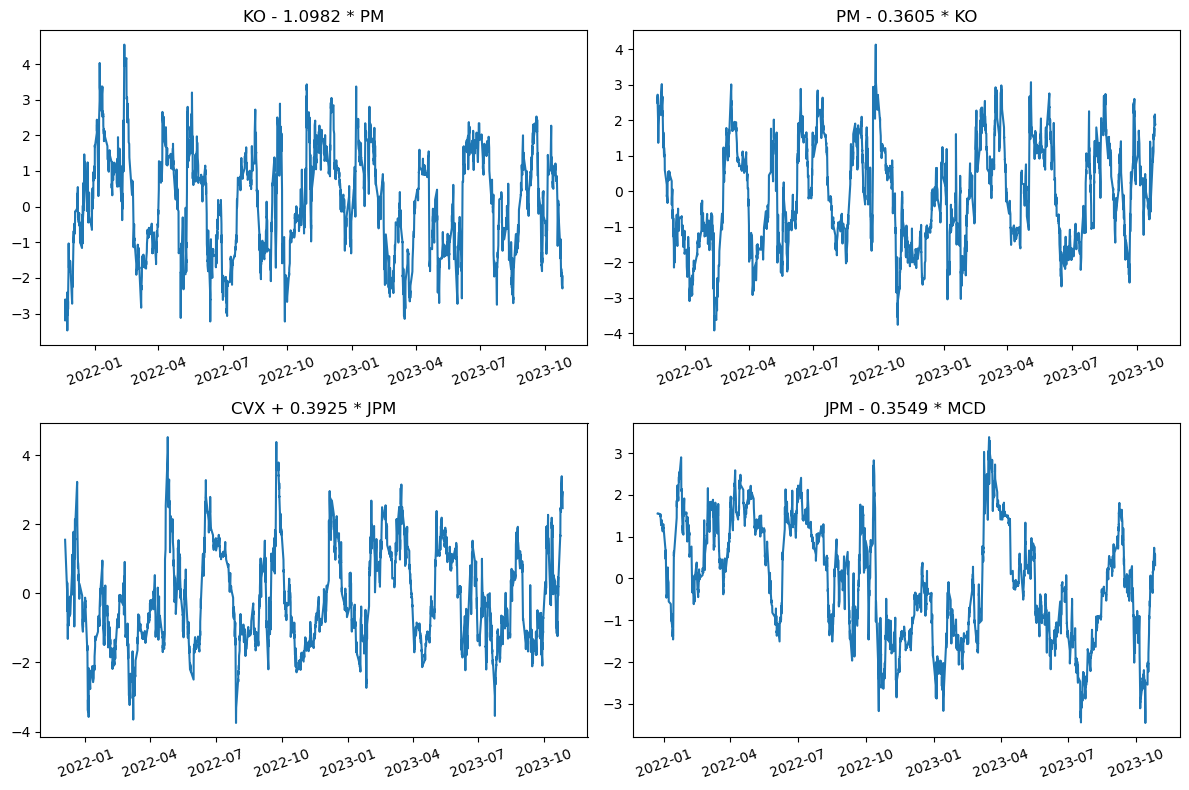

In [825]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i in range(len(mktVal)):
    row = i // 2
    col = i % 2
    axs[row, col].plot(mktVal[i].index, mktVal[i])
    axs[row, col].set_title(half_life_hedged_portfolio_df.index[i])
    axs[row, col].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

In [826]:
pnl = [mval.shift(1) * (price - price.shift(1)) / price.shift(1) for price, mval in zip((hedged_portfolio_df[portfolio] for portfolio in best_adf_hedged_portfolio_results_df.index), mktVal)]
pnl = [p.fillna(0).add(1) for p in pnl]

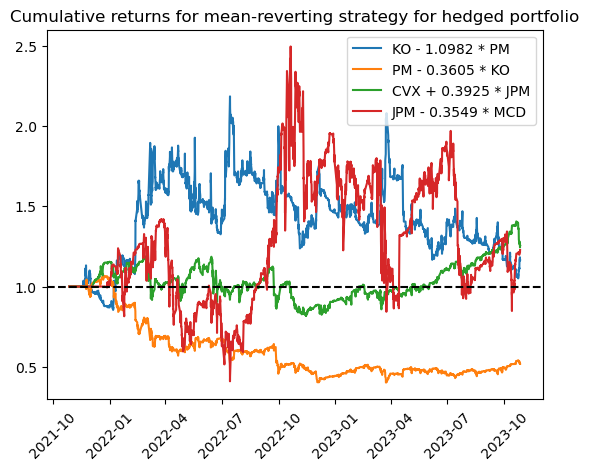

In [827]:
fig, ax = plt.subplots()

for p, ticker in zip(pnl, half_life_hedged_portfolio_df.index):
    ax.plot(p.cumprod(), label=ticker)
ax.legend()
plt.title('Cumulative returns for mean-reverting strategy for hedged portfolio')
ax.axhline(y=1, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()